## David Barranquero

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

2023-01-02 15:39:20.751781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline

In [3]:
print(tf.__version__)

2.10.0


Setting a random seed.

In [4]:
seed = 54321
np.random.seed(seed)
tf.random.set_seed(seed)

We're going to build a convolutional neural network for image classification. The dataset we will use is the MNIST Fashion Dataset, which contains 60,000 training images and 10,000 test images, all 28x28 and in greyscale. The dataset contains an equal amount of images of 10 different clothing articles. We begin first by reading in the dataset.

In [5]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [6]:
class_names = ["T-shirt/top", 
               "Trouser", 
               "Pullover", 
               "Dress", 
               "Coat", 
               "Sandal", 
               "Shirt", 
               "Sneaker", 
               "Bag", 
               "Ankle boot"]

Next, we visualise our dataset, viewing the first entry in the test dataset.

In [7]:
print(class_names[y_train[0]])

Ankle boot


As well as visualising the image itself.

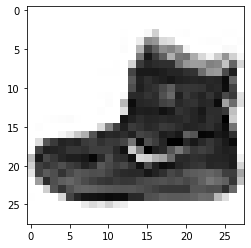

In [8]:
plt.imshow(X_train[0], cmap='Greys')

## Pre-processing

Firstly, we must perform pre-processing on the dataset. We are going to employ Min-Max normalisation on the dataset to place all values between 0 and 1. By normalising, the network will achieve a faster convergence to the local minimum. Fortunately, because of the 256 pixel values ranging from 0 to 255, the normalisation effect is achieved by simply dividing the dataset by 255. To do so, we first convert the dataset type to float, and then perform the normalisation. Furthermore, as general practice for when we deal with colour images and have three RGB colour channels, we reshape the dataset to include this information. We define a function for this preprocessing.

In [9]:
def normalise_data(dataset):
    dataset = dataset.reshape((dataset.shape[0], 28, 28, 1))
    dataset = dataset.astype('float32')
    dataset /= 255
    
    return dataset

In [10]:
X_train = normalise_data(X_train)
X_test = normalise_data(X_test)

Furthermore, we define a validation set using the first 10000 images of the training dataset. Ideally, when creating a validation set, it is wise to perform stratified sampling on your dataset. When there are large class imbalances, stratified sampling lowers the sampling variance of dataset split, which translates to better performance for the image classification model. However, if we look at the unique counts of the first 10000 images, we can see that there is a fairly uniform distribution of roughly a thousand per image, so the advantage of stratified sampling is minimal over simple random sampling.

In [11]:
np.unique(y_train[:10000], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 942, 1027, 1016, 1019,  974,  989, 1021, 1022,  990, 1000]))

For this reason, we will use the first 10000 images for our validation set, and the remaining 50000 for our training set.

In [12]:
X_valid, X_train = X_train[:10000], X_train[10000:]
y_valid, y_train = y_train[:10000], y_train[10000:]

Finally, we confirm the set sizes and shapes of our data

In [13]:
print(X_train.shape)
print(y_train.shape)

(50000, 28, 28, 1)
(50000,)


In [14]:
print(X_valid.shape)
print(y_valid.shape)

(10000, 28, 28, 1)
(10000,)


In [15]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28, 1)
(10000,)


## Building the Model

For image classification tasks, convolutional neural networks consistently provide the best performance.

Our model will consist of a convolutional layer with 32 filters and the standard 3x3 kernel size, with a stride of 1. We will use a layer of padding to ensure that the output is of the same shape and information is not lost. Finally, for our activation function we will use ReLU. ReLU is defined as ReLU(a) = max(0,a). It leads to faster convergence by promoting sparsity in the model, as well as avoiding the vanishing/exploding gradients issue of other activation functions. 

Next, we employ a pooling layer using max pooling, again using the standard 2x2 pool size with a step size of 2. Pooling layers are effective at reducing the dimensionality of the dataset while retaining the most important information.

Finally, we flatten the dataset in order to use the dense layers of standard feed-forward neural networks for the classification. We will use a layer with 100 layers, and the ReLU activation. Finally, we add an output layer, with the softmax activation, as this is a multi-class classification task.

In [16]:
model = keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3,3), strides=1, padding="same", activation="relu", input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

2023-01-02 15:40:20.885955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Our loss function for this model will be sparse categorical crossentropy, as the target variable contains only the sparse label vector position. We use stochastic gradient descent as our optimiser, which aids in speeding up the convergence to the local minima by taking faster, imprecise steps, rather than slow, precise steps of gradient descent. Finally, we use accuracy as our performance metric.

In [17]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

We can display a summary of our model as follows

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 100)               627300    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 628,630
Trainable params: 628,630
Non-trainable params: 0
__________________________________________________

Next, we fit the model and assess it's performance on the validation set. We will perform 10 sweeps over the entire dataset for training.

In [19]:
model_fit = model.fit(X_train, y_train, epochs=10, validation_data = (X_valid, y_valid))

Epoch 1/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.7293 - accuracy: 0.7483 - val_loss: 0.5478 - val_accuracy: 0.8049
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4893 - accuracy: 0.8256 - val_loss: 0.5032 - val_accuracy: 0.8230
Epoch 3/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4380 - accuracy: 0.8448 - val_loss: 0.4208 - val_accuracy: 0.8501
Epoch 4/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.4032 - accuracy: 0.8571 - val_loss: 0.4050 - val_accuracy: 0.8591
Epoch 5/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.3775 - accuracy: 0.8656 - val_loss: 0.3752 - val_accuracy: 0.8681
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 0.3580 - accuracy: 0.8719 - val_loss: 0.3746 - val_accuracy: 0.8683
Epoch 7/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.3403 - accuracy: 0.8776 - val_loss: 0.3488 -

And plot the performance of this model fit.

<AxesSubplot:>

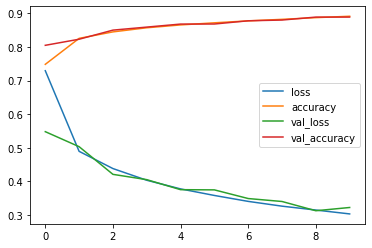

In [20]:
pd.DataFrame(model_fit.history).plot()

From the plot above, we can see that the training and validation accuracy has consistently increased and the training and validation loss have consistently decreased, which indicates that our model is learning correctly. Furthermore, the closeness of the training and validation curves indicate that our model is not overfitting, but generalising well to unseen data. Finally, we assess the performance of our model on the test dataset.

In [21]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3413 - accuracy: 0.8774


[0.3412894606590271, 0.8773999810218811]

## Fine-Tuning the Model

Having built our base model, we are now going to fine-tune our hyperparameters. For this we will define a function to build the model, and then use a scikit-learn wrapper so that we can use GridSearchCV for our grid search.

In [22]:
def build_model(n_neurons, opt_type):
    print('n_neurons: {0}, opt_type: {1}'.format(n_neurons, opt_type))
    model = keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), strides=1, padding="same", activation="relu", input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt_type, metrics=["accuracy"])
    
    return model

In [23]:
keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)

/var/folders/f_/3vhcqh5j54n5rh_ffnt1jks80000gn/T/ipykernel_14130/1566543695.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model)


While there are numerous hyperparameters we could optimise, for the sake of computational time and complexity, we are only going to optimise two, the number of neurons in the dense layer, and the optimiser used for the model. Adam is another popular optimiser that is very fast and efficient by combining the AdaGrad and RMSProp algorithms, which themselves extend on SGD.

In [24]:
parameters = {
    "n_neurons": [100, 200],
    "opt_type": ["sgd", "adam"]
}

For 4 potential hyperparameters, using 5-fold cross validaiton, 10 epochs and roughly 20 seconds training per epoch, the grid search should take just over an hour. However, using the more computationally intensive adam optimiser is likely to extend this runtime.

In [25]:
grid_search = GridSearchCV(keras_classifier, parameters, cv=5)

grid_search.fit(X_train, 
                y_train, 
                epochs=10, 
                validation_data = (X_valid, y_valid), 
                callbacks=EarlyStopping(patience=5))

n_neurons: 100, opt_type: sgd
Epoch 1/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.7690 - accuracy: 0.7366 - val_loss: 0.5145 - val_accuracy: 0.8202
Epoch 2/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5013 - accuracy: 0.8225 - val_loss: 0.5056 - val_accuracy: 0.8183
Epoch 3/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.4497 - accuracy: 0.8399 - val_loss: 0.4275 - val_accuracy: 0.8508
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4155 - accuracy: 0.8519 - val_loss: 0.3981 - val_accuracy: 0.8612
Epoch 5/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3933 - accuracy: 0.8623 - val_loss: 0.3881 - val_accuracy: 0.8646
Epoch 6/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3728 - accuracy: 0.8676 - val_loss: 0.3632 - val_accuracy: 0.8713
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3568 - accurac

Epoch 3/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.2355 - accuracy: 0.9143 - val_loss: 0.2630 - val_accuracy: 0.9042
Epoch 4/10
1250/1250 [==============================] - 21s 16ms/step - loss: 0.2043 - accuracy: 0.9248 - val_loss: 0.2539 - val_accuracy: 0.9058
Epoch 5/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.1728 - accuracy: 0.9386 - val_loss: 0.2627 - val_accuracy: 0.9099
Epoch 6/10
1250/1250 [==============================] - 21s 16ms/step - loss: 0.1502 - accuracy: 0.9449 - val_loss: 0.2453 - val_accuracy: 0.9140
Epoch 7/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.1319 - accuracy: 0.9513 - val_loss: 0.2662 - val_accuracy: 0.9122
Epoch 8/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.1113 - accuracy: 0.9597 - val_loss: 0.2635 - val_accuracy: 0.9185
Epoch 9/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.0942 - accuracy: 0.9653 - val_loss: 0.2762 -

Epoch 5/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.3788 - accuracy: 0.8662 - val_loss: 0.3768 - val_accuracy: 0.8677
Epoch 6/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.3580 - accuracy: 0.8731 - val_loss: 0.3487 - val_accuracy: 0.8767
Epoch 7/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3433 - accuracy: 0.8780 - val_loss: 0.3429 - val_accuracy: 0.8795
Epoch 8/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.3288 - accuracy: 0.8832 - val_loss: 0.3359 - val_accuracy: 0.8814
Epoch 9/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.3172 - accuracy: 0.8870 - val_loss: 0.3352 - val_accuracy: 0.8805
Epoch 10/10
313/313 [==============================] - 2s 6ms/step - loss: 0.3219 - accuracy: 0.8849
n_neurons: 200, opt_type: sgd
Epoch 1/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.7512 - accuracy: 0.7454 - val_loss: 0.5511 - val_accuracy: 

Epoch 7/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.1141 - accuracy: 0.9570 - val_loss: 0.2646 - val_accuracy: 0.9159
Epoch 8/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.0933 - accuracy: 0.9665 - val_loss: 0.2612 - val_accuracy: 0.9158
Epoch 9/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.0761 - accuracy: 0.9716 - val_loss: 0.2862 - val_accuracy: 0.9163
Epoch 10/10
313/313 [==============================] - 2s 5ms/step - loss: 0.3294 - accuracy: 0.9136
n_neurons: 200, opt_type: adam
Epoch 1/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4086 - accuracy: 0.8553 - val_loss: 0.3021 - val_accuracy: 0.8928
Epoch 2/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2722 - accuracy: 0.9007 - val_loss: 0.2641 - val_accuracy: 0.9036
Epoch 3/10
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2249 - accuracy: 0.9164 - val_loss: 0.2494 - val_accuracy:

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7eb53b7e50>,
             param_grid={'n_neurons': [100, 200], 'opt_type': ['sgd', 'adam']})

Having finished the hyperparameter fine tuning, the best parameters determined are as follows.

In [26]:
grid_search.best_params_

{'n_neurons': 200, 'opt_type': 'adam'}

These parameters have achieved the following validation score.

In [27]:
grid_search.best_score_

0.9144799947738648

## Optimial Model

Using this optimal model, we finally assess the performance on the test set.

In [28]:
optimal_model = grid_search.best_estimator_.model

In [29]:
optimal_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 6272)              0         
                                                                 
 dense_42 (Dense)            (None, 200)               1254600   
                                                                 
 dense_43 (Dense)            (None, 10)                2010      
                                                                 
Total params: 1,256,930
Trainable params: 1,256,930
Non-trainable params: 0
___________________________________________

In [30]:
optimal_model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3319 - accuracy: 0.9132


[0.33188846707344055, 0.9132000207901001]

As we can see, this has achieved a slightly better performance on the test dataset. Overall, we achieved very strong classification performance on the MNIST Fashion Dataset.